In [1]:
import numpy as np
import pandas as pd
import re
from collections import Counter
from scipy.sparse import csr_matrix
from scipy import sparse
import torch
from torch import nn
import random
import seaborn as sns

In [2]:
##########  NEEDS TO BE FIXED ###########
def better_tokenize(sentence):
    re1=r'\b[a-zA-z]{2,}\b'
    nltk_stopwords = {'ourselves', 'hers', 'between', 'yourself', 'but', 'again', 'there', 'about', 'once', 'during', 'out', 'very', 'having', 'with', 'they', 'own', 'an', 'be', 'some', 'for', 'do', 'its', 'yours', 'such', 'into', 'of', 'most', 'itself', 'other', 'off', 'is', 's', 'am', 'or', 'who', 'as', 'from', 'him', 'each', 'the', 'themselves', 'until', 'below', 'are', 'we', 'these', 'your', 'his', 'through', 'don', 'nor', 'me', 'were', 'her', 'more', 'himself', 'this', 'down', 'should', 'our', 'their', 'while', 'above', 'both', 'up', 'to', 'ours', 'had', 'she', 'all', 'no', 'when', 'at', 'any', 'before', 'them', 'same', 'and', 'been', 'have', 'in', 'will', 'on', 'does', 'yourselves', 'then', 'that', 'because', 'what', 'over', 'why', 'so', 'can', 'did', 'not', 'now', 'under', 'he', 'you', 'herself', 'has', 'just', 'where', 'too', 'only', 'myself', 'which', 'those', 'i', 'after', 'few', 'whom', 't', 'being', 'if', 'theirs', 'my', 'against', 'a', 'by', 'doing', 'it', 'how', 'further', 'was', 'here', 'than'} 
#     pattern=re.compile("%s|%s"%(re1,re2))
    pattern=re.compile(re1)
    
    token_list=pattern.findall(sentence)
    new_list=[]
    for i in range(len(token_list)):
        if token_list[i].lower() not in nltk_stopwords:
            new_list.append(token_list[i].lower())
    return new_list

def to_token(path):
    email_count=0
    corpus={}    # {word: index in dictionary}
    token_list=[]

    df=pd.read_csv(path)
    for email in df['email_text']:
        email_count+=1
        token_list+=better_tokenize(email)

    # counter counts the occurance of all words
    counter=Counter(token_list)

    idx=0
    words_set=set()
    for k,v in counter.items():
        if v>=10:
            corpus[k]=idx
            words_set.add(k)
            idx+=1

    # Build the csr sparse matrix
    row,col,val = [],[],[]
    for idx, email in df.iterrows():
        tokens = better_tokenize(email['email_text'])
        # Get count of each word in sentence
        ct_dict=Counter(tokens)  

        for word, ct in ct_dict.items():
            if word in words_set:
                i = corpus[word]        
                row.append(idx)
                col.append(i)
                val.append(ct)
    BoW=(csr_matrix((val, (row, col)),shape = (len(df),len(corpus))))
#     print(BoW)
    print(BoW.shape)
    return BoW,corpus,words_set

def get_Y_train(path):
    #Y_train:(data_num,1)
    df=pd.read_csv(path)
    dim=len(df)
    Y_train=np.zeros((dim,1))
    idx=0
    for party in df['party_affiliation']:
        if party=='Democratic Party':
            Y_train[idx][0]=1
        else:
            Y_train[idx][0]=0
        idx+=1
    return Y_train

def get_X_test(path,corpus,words_set):
    df=pd.read_csv(path)
    row,col,val = [],[],[]
    for idx, email in df.iterrows():
        tokens = better_tokenize(email['email_text'])
        # Get count of each word in sentence
        ct_dict=Counter(tokens)  

        for word, ct in ct_dict.items():
            if word in words_set:
                i = corpus[word]        
                row.append(idx)
                col.append(i)
                val.append(ct)
    BoW=(csr_matrix((val, (row, col)),shape = (len(df),len(corpus))))
    return BoW

X_train_np,corpus,words_set=to_token('train.csv')
Y_train_np=get_Y_train('train.csv')
X_dev_np=get_X_test('dev.csv',corpus,words_set)
Y_dev_np=get_Y_train('dev.csv')

(59999, 12070)


In [3]:
def to_sparse_tensor(X_train_np):    
#     X_train_coo=sparse.csr_matrix(X_train_np).tocoo()
#     X_train=torch.sparse.Tensor(torch.LongTensor([X_train_coo.row.tolist(),X_train_coo.col.tolist()]),
#                                    torch.LongTensor(X_train_coo.data.astype(np.int32)))
    
    return torch.from_numpy(X_train_np.toarray()).to_sparse()
    

In [4]:
X_train=to_sparse_tensor(X_train_np)
Y_train=torch.tensor(Y_train_np)
X_dev=to_sparse_tensor(X_dev_np)
Y_dev=torch.tensor(Y_dev_np)

In [5]:
n=X_train.size()[0]
input_dim=X_train.size()[1]

output_dim=1
# epoches=1000
learning_rate=5e-5
n

59999

In [6]:
class LogisticRegression(nn.Module):
    def __init__(self,input_dim,output_dim):
        super(LogisticRegression,self).__init__()
        self.linear=torch.nn.Linear(input_dim,output_dim)
    
    def forward(self,x):
        y=torch.sigmoid(self.linear(x))
        return y


    
model=LogisticRegression(input_dim,output_dim)



In [7]:
X_dev.shape

torch.Size([20000, 12070])

In [8]:
def evaluate_mode(X_eval,Y_eval,model):
    model.eval()
    loss_sum=0
    
    with torch.no_grad():
        Y_pred=model(X_eval.float())
#         print(Y_pred)
        loss = loss_func(Y_pred.float(), Y_eval.float())
        loss_sum+=loss.item()
        
    return loss_sum

In [9]:
def calculate_dev_F1(model):
    TP=0
    FP=0
    FN=0

    Y_dev_pred=model(X_dev.float())

    correct=0
#     print(Y_dev_pred)
    for i in range(Y_dev.shape[0]):
        if Y_dev_pred[i]>0.5:
            Y_dev_pred[i]=1
        elif Y_dev_pred[i]<0.5:
            Y_dev_pred[i]=0
        else:
            Y_dev_pred[i]=random.randint(0, 1)
    #     print(Y_dev_pred[i])
        if Y_dev_pred[i]==1 and Y_dev[i]==1:
            TP+=1
        elif Y_dev_pred[i]==0 and Y_dev[i]==1:
            FN+=1
        elif Y_dev_pred[i]==1 and Y_dev[i]==0:
            FP+=1
        if Y_dev_pred[i]==1 and Y_dev[i]==1 or Y_dev_pred[i]==0 and Y_dev[i]==0:
            correct+=1

    P=TP/(TP+FP)
    R=TP/(TP+FN)
    f1=2*P*R/(P+R)

    print("F1 value is:",f1)
    print("accuracy is:",correct/Y_dev.shape[0])
    return f1

## BCE Loss+SGD

### BCE +SGD for 1000 steps

In [56]:
model=LogisticRegression(input_dim,output_dim)

# loss function
loss_func=nn.BCELoss()
# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=9.7e-4)
steps=1000


losses = []
losses_dev = []
Iterations = []

num_list=random.sample(range(n),steps)
running_loss=0.0

for step in range(steps):
#     for name, param in model.named_parameters():
#         if param.requires_grad:
#             print (name, param.data)

    idx=num_list[step]
#     idx=step
    Y=Y_train[idx]
    X=X_train[idx]
#     print(X.to_dense())
    optimizer.zero_grad()
    Y_pred=model(X.float())
#     print(Y_pred)
    loss=loss_func(Y_pred.float(),Y.float())
#     print("loss.item:",loss.item())
        
    # backpropagation
    loss.backward()
    optimizer.step()
    
    running_loss+=loss.item()
    if (step+1)%100==0:
        losses.append(running_loss)
        print('[%d] loss: %.7f' % (step+1,running_loss))
        running_loss = 0.0
      
     
print("finish")
    

[100] loss: 50.3372219
[200] loss: 60.5590529
[300] loss: 39.0244211
[400] loss: 40.4771532
[500] loss: 45.5413563
[600] loss: 34.1800866
[700] loss: 42.8295864
[800] loss: 30.7136375
[900] loss: 31.1374027
[1000] loss: 33.5400345
finish


### SGD+BCE for 1 epochs, report loss every 1000 steps, do not add L2 penaly

In [60]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=9.7e-4)

losses = []
f1_dev = []
num_epoch=7
num_steps=1000
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()
    losses.append(running_loss)
    print('[%d] loss: %.7f' % ((step+1)*(epoch+1),running_loss))
    running_loss = 0.0
#     eval_loss=evaluate_mode(X_dev,Y_dev,model)
#     print("loss on dev set:",eval_loss)
    f1=calculate_dev_F1(model)
#     print("F1 on dev set:",f1)
    f1_dev.append(f1)
     
print("finish")

[1000] loss: 398.4125420
F1 value is: 0.9256844850065189
accuracy is: 0.87745
[2000] loss: 315.7804408
F1 value is: 0.9339093390933908
accuracy is: 0.88985
[3000] loss: 271.4409360
F1 value is: 0.9443504475959025
accuracy is: 0.90955
[4000] loss: 252.2728711
F1 value is: 0.9445752959065024
accuracy is: 0.90705
[5000] loss: 222.6211156
F1 value is: 0.9505609665885835
accuracy is: 0.9198
[6000] loss: 205.1914002
F1 value is: 0.9497814591802427
accuracy is: 0.91785
[7000] loss: 218.7829341
F1 value is: 0.9533513380800394
accuracy is: 0.924
finish


In [61]:
calculate_dev_F1(model)

F1 value is: 0.9533513380800394
accuracy is: 0.924


0.9533513380800394

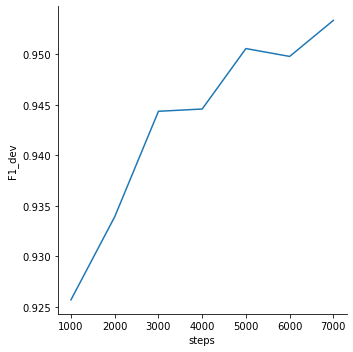

In [62]:
df = pd.DataFrame(dict(times=np.linspace(0,nums,num_epoch+1)[1:],F1=np.array(f1_dev)))
g = sns.relplot(x="times", y="F1", kind="line", data=df)
g.set(xlabel='steps',ylabel='F1_dev')
g.savefig('imgs/SGD_train_F1_epoch10_weight0.jpg')

In [59]:
losses


[68.58991611003876,
 63.9481543302536,
 61.15739542245865,
 62.2068652510643,
 52.34539704024792,
 56.41686528921127,
 56.836103320121765,
 55.673199102282524,
 57.824556313455105,
 54.19357330352068]

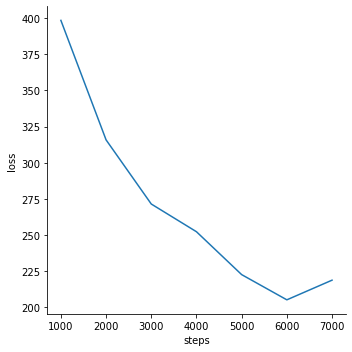

In [63]:
df = pd.DataFrame(dict(times=np.linspace(0,nums,num_epoch+1)[1:],loss=np.array(losses)))
g = sns.relplot(x="times", y="loss", kind="line", data=df)
g.set(xlabel='steps',ylabel='loss')
g.savefig('imgs/SGD_train_loss_epoch10_weight0.jpg')

# Adding Regularization

### SGD+BCE for 1 epochs, train on all data, report loss every 1000 steps, do not add L2 penalty

In [71]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=9.7e-4)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.6184813
loss on dev set: 0.5988893508911133
F1 value is: 0.891457146825948
accuracy is: 0.80465
F1 on dev set: 0.891457146825948
[1001] loss: 416.6180124
loss on dev set: 0.32689204812049866
F1 value is: 0.9174602244425561
accuracy is: 0.85915
F1 on dev set: 0.9174602244425561
[2001] loss: 342.5369068
loss on dev set: 0.32007890939712524
F1 value is: 0.9126031177524
accuracy is: 0.85115
F1 on dev set: 0.9126031177524
[3001] loss: 274.5795601
loss on dev set: 0.25494927167892456
F1 value is: 0.9293621967165481
accuracy is: 0.87845
F1 on dev set: 0.9293621967165481
[4001] loss: 274.7997920
loss on dev set: 0.2234138697385788
F1 value is: 0.9495296671490593
accuracy is: 0.9163
F1 on dev set: 0.9495296671490593
[5001] loss: 229.8174953
loss on dev set: 0.21464018523693085
F1 value is: 0.9471617279543022
accuracy is: 0.9112
F1 on dev set: 0.9471617279543022
[6001] loss: 222.0360206
loss on dev set: 0.20276345312595367
F1 value is: 0.9550637567435017
accuracy is: 0.9267
F1 on dev

F1 value is: 0.9697193047110128
accuracy is: 0.9507
F1 on dev set: 0.9697193047110128
[56001] loss: 135.2330007
loss on dev set: 0.13563640415668488
F1 value is: 0.9666595880229348
accuracy is: 0.94505
F1 on dev set: 0.9666595880229348
[57001] loss: 117.0645093
loss on dev set: 0.12322016805410385
F1 value is: 0.9707440256220744
accuracy is: 0.9525
F1 on dev set: 0.9707440256220744
[58001] loss: 128.9694820
loss on dev set: 0.12148059159517288
F1 value is: 0.9703352211847543
accuracy is: 0.95155
F1 on dev set: 0.9703352211847543
[59001] loss: 131.4085032
loss on dev set: 0.13398146629333496
F1 value is: 0.9676451280127544
accuracy is: 0.94825
F1 on dev set: 0.9676451280127544


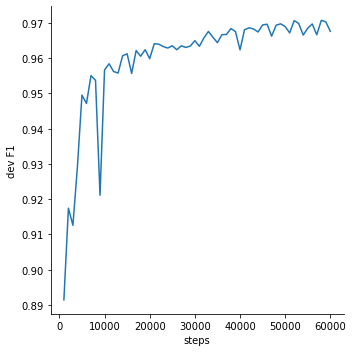

In [72]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_F1=np.array(f1_dev)))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('SGD_dev_F1_trainall_weight0.jpg')

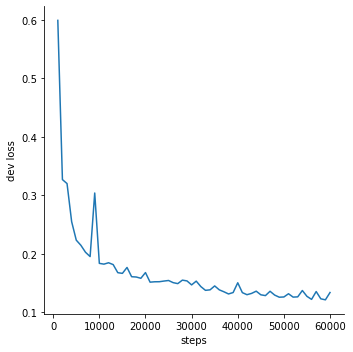

In [73]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('SGD_dev_loss_trainall_weight0.jpg')

### SGD+BCE for 1 epochs, train on all data, report loss every 1000 steps, weight_decay=0.1

In [77]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=9.7e-4,weight_decay=0.1)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.8636845
loss on dev set: 0.9486952424049377
F1 value is: 0.00766520368424306
accuracy is: 0.19735
F1 on dev set: 0.00766520368424306
[1001] loss: 402.6835614
loss on dev set: 0.3849920630455017
F1 value is: 0.8934430788054057
accuracy is: 0.8084
F1 on dev set: 0.8934430788054057
[2001] loss: 317.4471373
loss on dev set: 0.3042748272418976
F1 value is: 0.9401757337820154
accuracy is: 0.904
F1 on dev set: 0.9401757337820154
[3001] loss: 297.6918706
loss on dev set: 0.33659157156944275
F1 value is: 0.9217113206931437
accuracy is: 0.88005
F1 on dev set: 0.9217113206931437
[4001] loss: 277.9944711
loss on dev set: 0.2608766555786133
F1 value is: 0.947145482293581
accuracy is: 0.91515
F1 on dev set: 0.947145482293581
[5001] loss: 239.7009154
loss on dev set: 0.25691595673561096
F1 value is: 0.9254283320331685
accuracy is: 0.87095
F1 on dev set: 0.9254283320331685
[6001] loss: 238.0643257
loss on dev set: 0.2518720328807831
F1 value is: 0.9303043541575652
accuracy is: 0.88035
F1 o

F1 value is: 0.9593381339053164
accuracy is: 0.93365
F1 on dev set: 0.9593381339053164
[56001] loss: 221.5226420
loss on dev set: 0.20058667659759521
F1 value is: 0.9597596504005826
accuracy is: 0.9337
F1 on dev set: 0.9597596504005826
[57001] loss: 205.4725989
loss on dev set: 0.21823085844516754
F1 value is: 0.952301923904358
accuracy is: 0.9224
F1 on dev set: 0.952301923904358
[58001] loss: 192.8518648
loss on dev set: 0.20703530311584473
F1 value is: 0.9528450363196126
accuracy is: 0.9221
F1 on dev set: 0.9528450363196126
[59001] loss: 233.7652838
loss on dev set: 0.21589572727680206
F1 value is: 0.9428075236216995
accuracy is: 0.90285
F1 on dev set: 0.9428075236216995


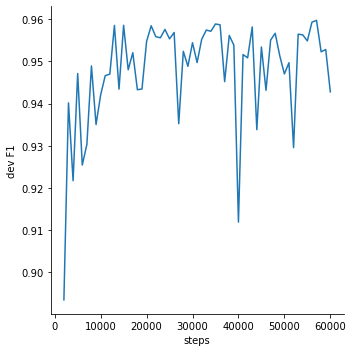

In [78]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[2:],dev_F1=np.array(f1_dev[1:])))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('SGD_dev_F1_trainall_weight01.jpg')

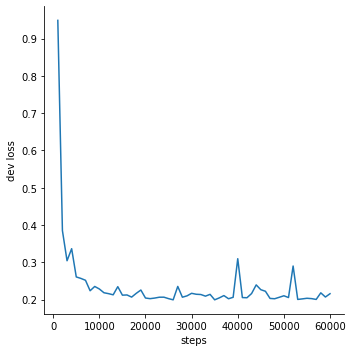

In [79]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('SGD_dev_loss_trainall_weight01.jpg')

### SGD+BCE for 1 epochs, train on all data, report loss every 1000 steps, weight_decay=0.001

In [ ]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=9.7e-4,weight_decay=0.001)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.7129643
loss on dev set: 0.5512538552284241
F1 value is: 0.8910594372606693
accuracy is: 0.8037
F1 on dev set: 0.8910594372606693
[1001] loss: 396.1437939
loss on dev set: 0.35697680711746216
F1 value is: 0.9100664593622341
accuracy is: 0.8525
F1 on dev set: 0.9100664593622341
[2001] loss: 331.1910484
loss on dev set: 0.3731842041015625
F1 value is: 0.9019389857110159
accuracy is: 0.85005
F1 on dev set: 0.9019389857110159
[3001] loss: 260.1079010
loss on dev set: 0.2913911044597626
F1 value is: 0.9167570653725378
accuracy is: 0.8542
F1 on dev set: 0.9167570653725378
[4001] loss: 258.6936785
loss on dev set: 0.25280267000198364
F1 value is: 0.9320178639189701
accuracy is: 0.88355
F1 on dev set: 0.9320178639189701
[5001] loss: 221.7628759
loss on dev set: 0.21371135115623474
F1 value is: 0.9485803376008156
accuracy is: 0.91425
F1 on dev set: 0.9485803376008156
[6001] loss: 227.7608364
loss on dev set: 0.22080542147159576
F1 value is: 0.9403821205330818
accuracy is: 0.8989
F1 

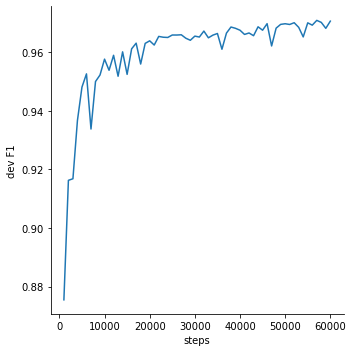

In [75]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_F1=np.array(f1_dev)))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('SGD_dev_F1_trainall_weight0001.jpg')

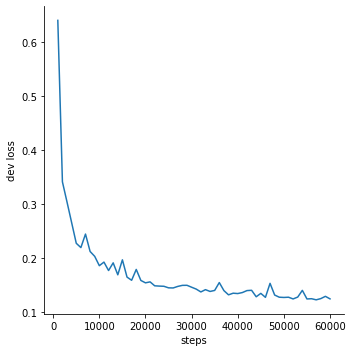

In [76]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('SGD_dev_loss_trainall_weight0001.jpg')

## BCE + AdamW

In [10]:

model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.6759956
loss on dev set: 0.6471728086471558
F1 value is: 0.8762393162393162
accuracy is: 0.7828
F1 on dev set: 0.8762393162393162
[1001] loss: 302.8579337
loss on dev set: 0.22727030515670776
F1 value is: 0.9540537983664974
accuracy is: 0.92715
F1 on dev set: 0.9540537983664974
[2001] loss: 176.9287828
loss on dev set: 0.1619335114955902
F1 value is: 0.9640344975227843
accuracy is: 0.9412
F1 on dev set: 0.9640344975227843
[3001] loss: 168.9610478
loss on dev set: 0.1740526556968689
F1 value is: 0.9541911576795298
accuracy is: 0.9283
F1 on dev set: 0.9541911576795298
[4001] loss: 146.1617100
loss on dev set: 0.1297328770160675
F1 value is: 0.969743605528025
accuracy is: 0.95085
F1 on dev set: 0.969743605528025
[5001] loss: 122.4515478
loss on dev set: 0.12475549429655075
F1 value is: 0.9693316677076828
accuracy is: 0.9509
F1 on dev set: 0.9693316677076828
[6001] loss: 122.0057465
loss on dev set: 0.12126974761486053
F1 value is: 0.9707348399131525
accuracy is: 0.95215
F1 on 

F1 value is: 0.9798533098133878
accuracy is: 0.96745
F1 on dev set: 0.9798533098133878
[56001] loss: 74.8144043
loss on dev set: 0.08863575011491776
F1 value is: 0.9788738891109812
accuracy is: 0.96565
F1 on dev set: 0.9788738891109812
[57001] loss: 124.7647487
loss on dev set: 0.08278860151767731
F1 value is: 0.979187314172448
accuracy is: 0.9664
F1 on dev set: 0.979187314172448
[58001] loss: 98.0079671
loss on dev set: 0.08159442991018295
F1 value is: 0.9795337908860446
accuracy is: 0.9669
F1 on dev set: 0.9795337908860446
[59001] loss: 85.8519763
loss on dev set: 0.0887337252497673
F1 value is: 0.978482724701832
accuracy is: 0.965
F1 on dev set: 0.978482724701832


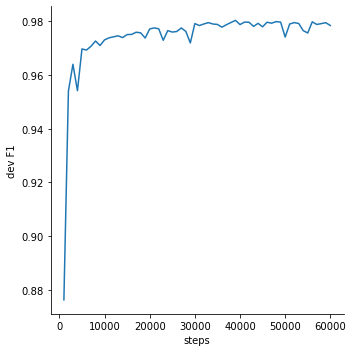

In [11]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_F1=np.array(f1_dev)))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('AdaW_dev_F1.jpg')

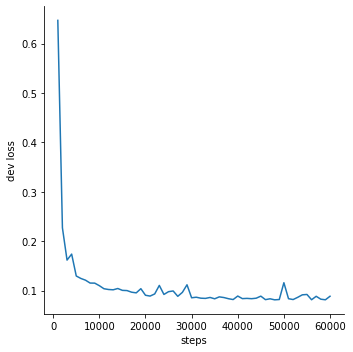

In [12]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('AdaW_dev_loss.jpg')

## BCE + RMSProp

In [41]:

model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.001, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0, centered=False)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.6605020
loss on dev set: 0.4844757914543152
F1 value is: 0.8917518632421799
accuracy is: 0.80465
F1 on dev set: 0.8917518632421799
[1001] loss: 279.1678935
loss on dev set: 0.19880834221839905
F1 value is: 0.9584949454845311
accuracy is: 0.93205
F1 on dev set: 0.9584949454845311
[2001] loss: 183.4517860
loss on dev set: 0.16704334318637848
F1 value is: 0.961438008910739
accuracy is: 0.93725
F1 on dev set: 0.961438008910739
[3001] loss: 169.1380977
loss on dev set: 0.15605461597442627
F1 value is: 0.9638087031451961
accuracy is: 0.9412
F1 on dev set: 0.9638087031451961
[4001] loss: 155.8226507
loss on dev set: 0.17427559196949005
F1 value is: 0.9551443286621153
accuracy is: 0.9251
F1 on dev set: 0.9551443286621153
[5001] loss: 140.8179550
loss on dev set: 0.15592801570892334
F1 value is: 0.9624946811743966
accuracy is: 0.9383
F1 on dev set: 0.9624946811743966
[6001] loss: 163.9663542
loss on dev set: 0.14540478587150574
F1 value is: 0.9655638082376773
accuracy is: 0.9439
F1 

F1 value is: 0.965351861530421
accuracy is: 0.94365
F1 on dev set: 0.965351861530421
[56001] loss: 158.0425956
loss on dev set: 0.1456575244665146
F1 value is: 0.9650593562599437
accuracy is: 0.9429
F1 on dev set: 0.9650593562599437
[57001] loss: 143.6903095
loss on dev set: 0.145064577460289
F1 value is: 0.9645060293251495
accuracy is: 0.94275
F1 on dev set: 0.9645060293251495
[58001] loss: 134.1379379
loss on dev set: 0.15576566755771637
F1 value is: 0.9621775982015371
accuracy is: 0.93775
F1 on dev set: 0.9621775982015371
[59001] loss: 177.1903528
loss on dev set: 0.14654281735420227
F1 value is: 0.965040600012397
accuracy is: 0.9436
F1 on dev set: 0.965040600012397


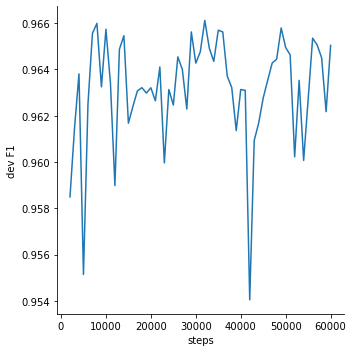

In [44]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[2:],dev_F1=np.array(f1_dev[1:])))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('imgs/RMS_dev_F1_basic.jpg')

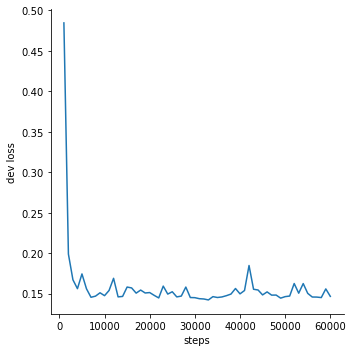

In [45]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('imgs/RMS_dev_loss_basic.jpg')

In [51]:

model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.RMSprop(model.parameters(), lr=0.01, alpha=0.99, eps=1e-08, weight_decay=0.01, momentum=0.00001, centered=False)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.6801432
loss on dev set: 3.5999274253845215
F1 value is: 0.8917705735660848
accuracy is: 0.8047
F1 on dev set: 0.8917705735660848
[1001] loss: 488.5682946
loss on dev set: 0.24563723802566528
F1 value is: 0.9415363048395833
accuracy is: 0.90825
F1 on dev set: 0.9415363048395833
[2001] loss: 429.6971798
loss on dev set: 0.5639116764068604
F1 value is: 0.9310918483495315
accuracy is: 0.88195
F1 on dev set: 0.9310918483495315
[3001] loss: 407.8673280
loss on dev set: 0.3460640013217926
F1 value is: 0.9457744792913575
accuracy is: 0.9094
F1 on dev set: 0.9457744792913575
[4001] loss: 581.5204878
loss on dev set: 0.26971742510795593
F1 value is: 0.9410608414444692
accuracy is: 0.90705
F1 on dev set: 0.9410608414444692
[5001] loss: 261.2446844
loss on dev set: 0.22026164829730988
F1 value is: 0.9509554335490601
accuracy is: 0.92005
F1 on dev set: 0.9509554335490601
[6001] loss: 372.9699507
loss on dev set: 0.34393760561943054
F1 value is: 0.9361637327160869
accuracy is: 0.8952
F1

F1 value is: 0.900848907828071
accuracy is: 0.85225
F1 on dev set: 0.900848907828071
[56001] loss: 589.7300639
loss on dev set: 0.33981236815452576
F1 value is: 0.9426096538214318
accuracy is: 0.90625
F1 on dev set: 0.9426096538214318
[57001] loss: 296.8566045
loss on dev set: 0.38439199328422546
F1 value is: 0.9166342790516907
accuracy is: 0.8713
F1 on dev set: 0.9166342790516907
[58001] loss: 407.2581999
loss on dev set: 0.2963831424713135
F1 value is: 0.9276203372344198
accuracy is: 0.88775
F1 on dev set: 0.9276203372344198
[59001] loss: 272.1751469
loss on dev set: 1.0296802520751953
F1 value is: 0.7804144259335866
accuracy is: 0.70805
F1 on dev set: 0.7804144259335866


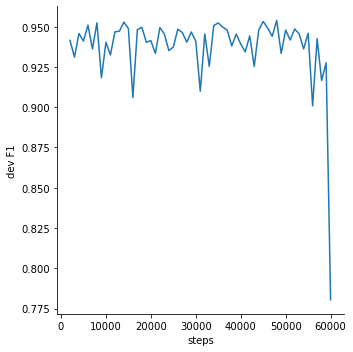

In [52]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[2:],dev_F1=np.array(f1_dev[1:])))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('imgs/RMS_dev_F1.jpg')

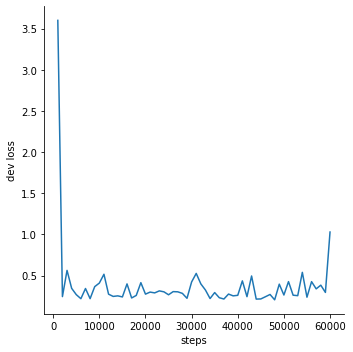

In [53]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('imgs/RMS_dev_loss.jpg')

## SGD, learning rate influence

### Very large learning rate

In [17]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=0.01)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.6120245
loss on dev set: 0.6648670434951782
F1 value is: 0.8917825677397905
accuracy is: 0.8047
F1 on dev set: 0.8917825677397905
[1001] loss: 1324.0431014
loss on dev set: 0.8803588151931763
F1 value is: 0.9105125477908415
accuracy is: 0.84435
F1 on dev set: 0.9105125477908415
[2001] loss: 471.1311211
loss on dev set: 0.23203440010547638
F1 value is: 0.9466981875492514
accuracy is: 0.91545
F1 on dev set: 0.9466981875492514
[3001] loss: 476.7412872
loss on dev set: 1.2196121215820312
F1 value is: 0.9135610766045549
accuracy is: 0.8497
F1 on dev set: 0.9135610766045549
[4001] loss: 921.0092471
loss on dev set: 0.34527695178985596
F1 value is: 0.9454127442756391
accuracy is: 0.91215
F1 on dev set: 0.9454127442756391
[5001] loss: 401.2768088
loss on dev set: 0.22835256159305573
F1 value is: 0.9579677241210038
accuracy is: 0.9315
F1 on dev set: 0.9579677241210038
[6001] loss: 364.2032151
loss on dev set: 0.5064033269882202
F1 value is: 0.9413883721616914
accuracy is: 0.90075
F1

F1 value is: 0.969859427110931
accuracy is: 0.95165
F1 on dev set: 0.969859427110931
[56001] loss: 462.7538654
loss on dev set: 0.18276773393154144
F1 value is: 0.9725704128229489
accuracy is: 0.95525
F1 on dev set: 0.9725704128229489
[57001] loss: 322.3530707
loss on dev set: 0.15451562404632568
F1 value is: 0.9728963902919798
accuracy is: 0.956
F1 on dev set: 0.9728963902919798
[58001] loss: 177.8101144
loss on dev set: 0.2878175675868988
F1 value is: 0.9655234875015095
accuracy is: 0.9429
F1 on dev set: 0.9655234875015095
[59001] loss: 361.8073671
loss on dev set: 0.39932188391685486
F1 value is: 0.9599184578948945
accuracy is: 0.93315
F1 on dev set: 0.9599184578948945


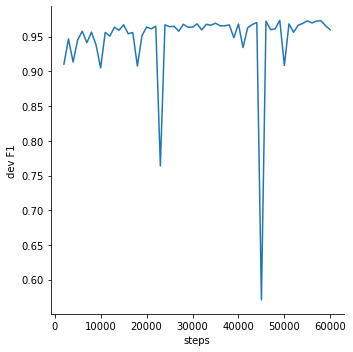

In [18]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[2:],dev_F1=np.array(f1_dev[1:])))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('imgs/SGD_dev_F1_lr_large.jpg')

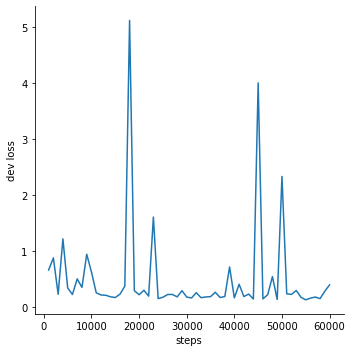

In [19]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('imgs/SGD_dev_loss_lr_large.jpg')

### Very small learning rate

In [26]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=1e-7)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.5809110
loss on dev set: 0.7588133811950684
F1 value is: 0.08636945640786871
accuracy is: 0.2151
F1 on dev set: 0.08636945640786871
[1001] loss: 749.1185979
loss on dev set: 0.7507625818252563
F1 value is: 0.1255879852649476
accuracy is: 0.22855
F1 on dev set: 0.1255879852649476
[2001] loss: 745.8537415
loss on dev set: 0.7427696585655212
F1 value is: 0.1766958424507659
accuracy is: 0.2475
F1 on dev set: 0.1766958424507659
[3001] loss: 734.6306406
loss on dev set: 0.734932541847229
F1 value is: 0.23145618827484768
accuracy is: 0.2685
F1 on dev set: 0.23145618827484768
[4001] loss: 731.7169555
loss on dev set: 0.7277180552482605
F1 value is: 0.29259706296519816
accuracy is: 0.2967
F1 on dev set: 0.29259706296519816
[5001] loss: 725.2356741
loss on dev set: 0.7206584811210632
F1 value is: 0.3597630875047764
accuracy is: 0.3298
F1 on dev set: 0.3597630875047764
[6001] loss: 720.1185858
loss on dev set: 0.7133723497390747
F1 value is: 0.43633093525179856
accuracy is: 0.3732
F1 

[56001] loss: 552.9469601
loss on dev set: 0.5529145002365112
F1 value is: 0.8912983195607564
accuracy is: 0.804
F1 on dev set: 0.8912983195607564
[57001] loss: 561.0637583
loss on dev set: 0.5517951250076294
F1 value is: 0.8912983195607564
accuracy is: 0.804
F1 on dev set: 0.8912983195607564
[58001] loss: 544.8300982
loss on dev set: 0.5504103302955627
F1 value is: 0.8912549215327457
accuracy is: 0.8039
F1 on dev set: 0.8912549215327457
[59001] loss: 546.1979016
loss on dev set: 0.5491102933883667
F1 value is: 0.891285662794244
accuracy is: 0.80395
F1 on dev set: 0.891285662794244


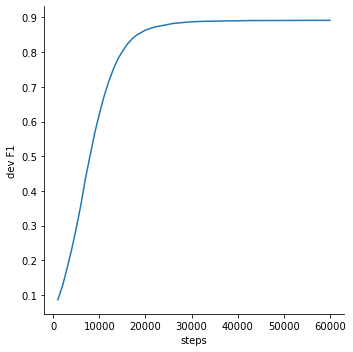

In [27]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_F1=np.array(f1_dev)))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('imgs/SGD_dev_F1_lr_smallest.jpg')

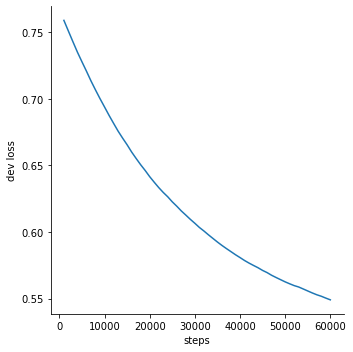

In [28]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('imgs/SGD_dev_loss_lr_smallest.jpg')

In [20]:
model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.SGD(model.parameters(),lr=0.001)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=1
num_steps=n
nums=num_epoch*num_steps
num_list=random.sample(range(n),nums)
running_loss=0.0

for epoch in range(num_epoch):
    for step in range(num_steps):
        idx=num_list[step+epoch*num_steps]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



[1] loss: 0.7044010
loss on dev set: 0.6771939396858215
F1 value is: 0.7491519731318219
accuracy is: 0.62655
F1 on dev set: 0.7491519731318219
[1001] loss: 417.8086572
loss on dev set: 0.3576442003250122
F1 value is: 0.9100712849570463
accuracy is: 0.8524
F1 on dev set: 0.9100712849570463
[2001] loss: 309.2452563
loss on dev set: 0.28516384959220886
F1 value is: 0.9394126738794436
accuracy is: 0.902
F1 on dev set: 0.9394126738794436
[3001] loss: 292.5222364
loss on dev set: 0.2612367272377014
F1 value is: 0.9301889556174016
accuracy is: 0.88085
F1 on dev set: 0.9301889556174016
[4001] loss: 232.0020055
loss on dev set: 0.23421086370944977
F1 value is: 0.9416056211690836
accuracy is: 0.90235
F1 on dev set: 0.9416056211690836
[5001] loss: 228.0160615
loss on dev set: 0.2597433626651764
F1 value is: 0.9325629577752488
accuracy is: 0.88445
F1 on dev set: 0.9325629577752488
[6001] loss: 229.7724584
loss on dev set: 0.2061333954334259
F1 value is: 0.953977186311787
accuracy is: 0.92435
F1 on

F1 value is: 0.9688869815774147
accuracy is: 0.94925
F1 on dev set: 0.9688869815774147
[56001] loss: 119.1962398
loss on dev set: 0.12073740363121033
F1 value is: 0.9705222389573663
accuracy is: 0.95205
F1 on dev set: 0.9705222389573663
[57001] loss: 151.7647164
loss on dev set: 0.1236577033996582
F1 value is: 0.9691247924226581
accuracy is: 0.9498
F1 on dev set: 0.9691247924226581
[58001] loss: 129.2896616
loss on dev set: 0.12060097604990005
F1 value is: 0.9702630692432548
accuracy is: 0.95145
F1 on dev set: 0.9702630692432548
[59001] loss: 132.4286188
loss on dev set: 0.13132043182849884
F1 value is: 0.967582760774516
accuracy is: 0.9481
F1 on dev set: 0.967582760774516


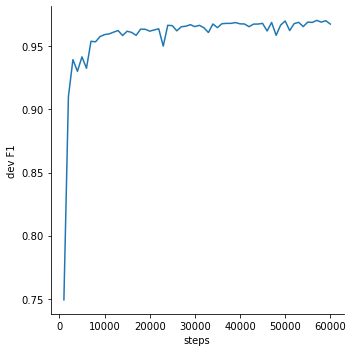

In [21]:
df_f1 = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_F1=np.array(f1_dev)))
g = sns.relplot(x="steps", y="dev_F1", kind="line", data=df_f1)
g.set(xlabel='steps',ylabel='dev F1')
g.savefig('imgs/SGD_dev_F1_lr_small.jpg')

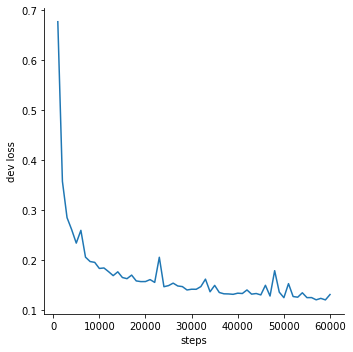

In [22]:
df_loss = pd.DataFrame(dict(steps=np.linspace(0,60000,len(f1_dev)+1)[1:],dev_loss=np.array(losses_dev)))
g = sns.relplot(x="steps", y="dev_loss", kind="line", data=df_loss)
g.set(xlabel='steps',ylabel='dev loss')
g.savefig('imgs/SGD_dev_loss_lr_small.jpg')

## Best prediction
### torch.optim.AdamW(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False), train on whole

In [19]:
X_test_np=get_X_test('test.csv',corpus,words_set)

X_test=to_sparse_tensor(X_test_np)
Y_test_pred=model(X_test.float())
Y_pred=[]
for i in range(Y_dev.shape[0]):
#     print(Y_dev_pred[i])
    if Y_test_pred[i]>0.5:
        Y_pred.append('Democratic Party')
    elif Y_test_pred[i]<0.5:
        Y_pred.append('Republican Party')
    else:
        Y_text_pred[i]=rand()%2
        if Y_text_pred[i]==1:
            Y_pred.append('Democratic Party')
        else:
            Y_pred.append('Republican Party')

In [20]:
df_test=pd.read_csv('test.csv')
title=df_test['uid_email'].to_numpy()

d={'uid_email':title,'party_affiliation':Y_pred}
df_out=pd.DataFrame(data=d)
df_out.to_csv('submission2.csv',index=False)

In [18]:

model=LogisticRegression(input_dim,output_dim)

loss_func=nn.BCELoss()

# optimizer
optimizer=torch.optim.AdamW(model.parameters(), lr=0.0011, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.01, amsgrad=False)

losses = []
losses_dev = []
f1_dev=[]
num_epoch=2
num_steps=30000
nums=num_epoch*num_steps
# num_list=random.sample(range(num_steps),nums)
running_loss=0.0

for epoch in range(num_epoch):
    print("epoch:",epoch)
    num_list=random.sample(range(n),num_steps)
    for step in range(num_steps):
        idx=num_list[step]
        Y=Y_train[idx]
        X=X_train[idx]
        optimizer.zero_grad()
        Y_pred=model(X.float())
        loss=loss_func(Y_pred.float(),Y.float())

        # backpropagation
        loss.backward()
        optimizer.step()

        running_loss+=loss.item()

        if step%1000==0:
            losses.append(running_loss)
            print('[%d] loss: %.7f' % (step + 1,running_loss))
            running_loss = 0.0
            eval_loss=evaluate_mode(X_dev,Y_dev,model)
            print("loss on dev set:",eval_loss)
            losses_dev.append(eval_loss)
            f1=calculate_dev_F1(model)
            print("F1 on dev set:",f1)
            f1_dev.append(f1)



epoch: 0
[1] loss: 0.5885429
loss on dev set: 0.6324145793914795
F1 value is: 0.8807024456139363
accuracy is: 0.78805
F1 on dev set: 0.8807024456139363
[1001] loss: 305.1490057
loss on dev set: 0.21889802813529968
F1 value is: 0.9438941937014411
accuracy is: 0.9054
F1 on dev set: 0.9438941937014411
[2001] loss: 170.5306960
loss on dev set: 0.1693698912858963
F1 value is: 0.9623461929873254
accuracy is: 0.93895
F1 on dev set: 0.9623461929873254
[3001] loss: 180.6076487
loss on dev set: 0.1451997607946396
F1 value is: 0.9651102661596959
accuracy is: 0.94265
F1 on dev set: 0.9651102661596959
[4001] loss: 143.9008891
loss on dev set: 0.13427120447158813
F1 value is: 0.9683318601603219
accuracy is: 0.94805
F1 on dev set: 0.9683318601603219
[5001] loss: 141.5201918
loss on dev set: 0.12711679935455322
F1 value is: 0.969693217348234
accuracy is: 0.95105
F1 on dev set: 0.969693217348234
[6001] loss: 132.1366301
loss on dev set: 0.1185171902179718
F1 value is: 0.9713632572364153
accuracy is: 0.

F1 value is: 0.9788114652829255
accuracy is: 0.9657
F1 on dev set: 0.9788114652829255
[26001] loss: 96.1128621
loss on dev set: 0.08958956599235535
F1 value is: 0.9779400389839424
accuracy is: 0.96435
F1 on dev set: 0.9779400389839424
[27001] loss: 65.1362822
loss on dev set: 0.08943213522434235
F1 value is: 0.9785465849979993
accuracy is: 0.96515
F1 on dev set: 0.9785465849979993
[28001] loss: 59.1150563
loss on dev set: 0.08680824935436249
F1 value is: 0.9787956418407975
accuracy is: 0.96565
F1 on dev set: 0.9787956418407975
[29001] loss: 103.0590176
loss on dev set: 0.08621853590011597
F1 value is: 0.978380722294493
accuracy is: 0.9651
F1 on dev set: 0.978380722294493
